In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving en_py_converter.zip to en_py_converter.zip
User uploaded file "en_py_converter.zip" with length 95057 bytes


In [ ]:
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install -q tensorflow-text-nightly
!pip install -q tensorflow_datasets
!pip install -q tf-nightly

!pip install tensorflow
import tensorflow_text as text
import tensorflow as tf

     |████████████████████████████████| 4.5MB 8.5MB/s 
     |████████████████████████████████| 404.1MB 44kB/s 
     |████████████████████████████████| 4.0MB 50.2MB/s 
     |████████████████████████████████| 6.0MB 47.2MB/s 
     |████████████████████████████████| 471kB 58.5MB/s 
     |████████████████████████████████| 4.0MB 45.3MB/s 
     |████████████████████████████████| 3.8MB 42.6MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
     |████████████████████████████████| 3.8MB 9.0MB/s 
     |████████████████████████████████| 2.9MB 53.7MB/s 
ERROR: tf-nightly 2.5.0.dev20210306 has requirement gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20210306 has requirement grpcio~=1.34.0,

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = {}
test = {}
with open('all.anno') as json_file: 
    en = json_file.read()
    en = en.splitlines()
    new_en = []
    for line in en:
      new_en.append(line.strip())
    print(new_en)
    print(len(new_en))
with open('all.code') as json_file: 
    py = json_file.read()
    py = py.splitlines()
    new_py = []
    for line in py:
      new_py.append(line.strip())
    print(new_py)
    print(len(new_py))

['from threading import local into default name space.', 'import module warnings.', 'from django.conf import settings into default name space.', 'from django.core import signals into default name space.', 'from django.core.cache.backends.base import InvalidCacheBackendError, CacheKeyWarning and BaseCache into default name space.', 'from django.core.exceptions import ImproperlyConfigured into default name space.', 'from django.utils.deprecation import RemovedInDjango19Warning into default name space.', 'from django.utils.module_loading import import_string into default name space.', "__all__ is an list containing 6 elements: 'get_cache', 'cache', 'DEFAULT_CACHE_ALIAS', 'InvalidCacheBackendError',", "'CacheKeyWarning' and 'BaseCache'   DEFAULT_CACHE_ALIAS is a string 'default'.", 'if DEFAULT_CACHE_ALIAS is not contained in settings.CACHES,', 'raise an exception ImproperlyConfigured with string "You must define a \'%s\' cache" as argument, with \'%s\' replaced with DEFAULT_CACHE_ALIAS con

In [ ]:
train_dict = {}
train_dict['en'] = []
train_dict['py'] = []
for x ,y in zip(new_en[:15000], new_py[:15000]):
  # print(x,y)
  train_dict['en'].append(x)
  train_dict['py'].append(y)

In [ ]:
test_dict = {}
test_dict['en'] = []
test_dict['py'] = []
for x ,y in zip(new_en[15000:], new_py[15000:]):
  # print(x,y)
  test_dict['en'].append(x)
  test_dict['py'].append(y)

In [ ]:
train_df = pd.DataFrame(train_dict)
val_df = pd.DataFrame(test_dict)
print(train_df)
print(val_df)

                                                      en                                                 py
0      from threading import local into default name ...                        from threading import local
1                                import module warnings.                                    import warnings
2      from django.conf import settings into default ...                 from django . conf import settings
3      from django.core import signals into default n...                  from django . core import signals
4      from django.core.cache.backends.base import In...  from django . core . cache . backends . base i...
...                                                  ...                                                ...
14995  define the method configure_custom with 2 argu...           def configure_custom ( self , config ) :
14996  remove config dictionary element under '()' ke...                          c = config . pop ( '()' )
14997  if c doesnt have an a

In [ ]:
train_df.isna().sum()

en    0
py    0
dtype: int64

In [ ]:
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)

In [ ]:
train_examples = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_df['en'].values, tf.string),
            tf.cast(train_df['py'].values, tf.string)
        )
    )
)
val_examples = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(val_df['en'].values, tf.string),
            tf.cast(val_df['py'].values, tf.string)
        )
    )
)
print(train_examples)
print(val_examples)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>
<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>


In [ ]:
train_en_arr_ = pd.Series([x['rewritten_intent'] for x in train])
train_py_arr_ = pd.Series([x['snippet'] for x in train])
test_en_arr_ = pd.Series([x['rewritten_intent'] for x in test])
test_py_arr_ = pd.Series([x['snippet'] for x in test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future versio

In [ ]:
train_en_arr = []
train_py_arr = []
for i in range(len(train_en_arr_)):
  if train_en_arr_[i] != None and train_py_arr_[i] != None:
    train_en_arr.append(train_en_arr_[i])
    train_py_arr.append(train_py_arr_[i])
    i -= 1

test_en_arr = []
test_py_arr = []
for i in range(len(test_en_arr_)):
  if test_en_arr_[i] != None and test_py_arr_[i] != None:
    test_en_arr.append(test_en_arr_[i])
    test_py_arr.append(test_py_arr_[i])
    i -= 1

In [ ]:
train_en = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(new_en[:15000], tf.string)
        )
    )
)

train_py = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(new_py[:15000], tf.string)
        )
    )
)

val_en = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(new_en[15000:], tf.string)
        )
    )
)

var_py = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(new_py[15000:], tf.string)
        )
    )
)

In [ ]:
train_en

<TensorSliceDataset shapes: (), types: tf.string>

In [ ]:
train_py

<TensorSliceDataset shapes: (), types: tf.string>

In [ ]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [ ]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

# import requests
# url = "https://github.com/tensorflow/text/blob/master/tensorflow_text/python/ops/test_data/test_oss_model.model?raw=true"
# sp_model = requests.get(url).content

# tokenizer = tf_text.SentencepieceTokenizer(sp_model, out_type=tf.string)
# tokens = tokenizer.tokenize(["What you know you can't explain, but you feel it."])
# print(tokens.to_list())

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 4000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [ ]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings


In [ ]:
py_vocab = bert_vocab.bert_vocab_from_dataset(
    train_py.batch(1000).prefetch(2),
    **bert_vocab_args
)

In [ ]:
print(len(py_vocab))
print(py_vocab[:10])
print(py_vocab[100:110])
print(py_vocab[1000:1010])
print(py_vocab[-10:])

1276
['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '#', '$', '%', '&']
['and', 'default', 'template', 'file', 'true', 'except', 'kwargs', 'false', 'try', 'parser']
['prog', 'push', 'rb', 'reraise', 'ret', 'seen', 'shell', 'socket', 'strftime', 'title']
['##]', '##^', '##_', '##`', '##j', '##z', '##{', '##|', '##}', '##~']


In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
write_vocab_file('py_vocab.txt', py_vocab)

In [ ]:
%%time
en_vocab = bert_vocab.bert_vocab_from_dataset(
    train_en.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 10.9 s, sys: 17.5 ms, total: 11 s
Wall time: 10.9 s


In [ ]:
print(len(en_vocab))
print(en_vocab[:10])
print(en_vocab[100:110])
print(en_vocab[1000:1010])
print(en_vocab[-10:])

1371
['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '#', '$', '%', '&']
['in', 'not', 'it', 'true', 'list', 'default', 'none', 'import', 'into', 'base']
['backends', 'basedir', 'client', 'cmd', 'coerce', 'complain', 'conditional', 'construct', 'converter', 'dependencies']
['##]', '##^', '##_', '##`', '##j', '##z', '##{', '##|', '##}', '##~']


In [ ]:
write_vocab_file('en_vocab.txt', en_vocab)

In [ ]:
!ls *.txt

en_vocab.txt  py_vocab.txt


In [ ]:
py_tokenizer = text.BertTokenizer('py_vocab.txt', **bert_tokenizer_params)
en_tokenizer = text.BertTokenizer('en_vocab.txt', **bert_tokenizer_params)

In [ ]:
for en_examples, py_examples in train_examples.batch(3).take(1):
  for ex in en_examples:
    print(ex.numpy())
  for py in py_examples:
    print(py.numpy())


b'from threading import local into default name space.'
b'import module warnings.'
b'from django.conf import settings into default name space.'
b'from threading import local'
b'import warnings'
b'from django . conf import settings'


In [ ]:
# Tokenize the examples -> (batch, word, word-piece)
token_batch = py_tokenizer.tokenize(py_examples)
# Merge the word and word-piece axes -> (batch, tokens)
token_batch = token_batch.merge_dims(-2,-1)

for ex in token_batch.to_list():
  print(ex)

[81, 698, 79, 935]
[79, 337]
[81, 84, 17, 312, 79, 119]


In [ ]:
# Lookup each token id in the vocabulary.
txt_tokens = tf.gather(py_vocab, token_batch)
# Join with spaces.
tf.strings.reduce_join(txt_tokens, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'from threading import local', b'import warnings',
       b'from django . conf import settings'], dtype=object)>

In [ ]:
words = py_tokenizer.detokenize(token_batch)
tf.strings.reduce_join(words, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'from threading import local', b'import warnings',
       b'from django . conf import settings'], dtype=object)>

In [ ]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

In [ ]:
words = py_tokenizer.detokenize(add_start_end(token_batch))
tf.strings.reduce_join(words, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'[START] from threading import local [END]',
       b'[START] import warnings [END]',
       b'[START] from django . conf import settings [END]'], dtype=object)>

In [ ]:
def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)
    
  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [ ]:
py_examples.numpy()

array([b'from threading import local', b'import warnings',
       b'from django . conf import settings'], dtype=object)

In [ ]:
token_batch = py_tokenizer.tokenize(py_examples).merge_dims(-2,-1)
words = py_tokenizer.detokenize(token_batch)
words

<tf.RaggedTensor [[b'from', b'threading', b'import', b'local'], [b'import', b'warnings'], [b'from', b'django', b'.', b'conf', b'import', b'settings']]>

In [ ]:
cleanup_text(reserved_tokens, words).numpy()

array([b'from threading import local', b'import warnings',
       b'from django . conf import settings'], dtype=object)

In [ ]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    
    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()
    
  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [ ]:
tokenizers = tf.Module()
tokenizers.py = CustomTokenizer(reserved_tokens, 'py_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'en_vocab.txt')

In [ ]:
model_name = 'en_py_converter'
tf.saved_model.save(tokenizers, model_name)

In [ ]:
reloaded_tokenizers = tf.saved_model.load(model_name)
reloaded_tokenizers.py.get_vocab_size().numpy()

1276

In [ ]:
tokens = reloaded_tokenizers.py.tokenize(['for i in arr:'])
tokens.numpy()

array([[  2,  83,  50,  80,  42, 220, 220,  29,   3]])

In [ ]:
text_tokens = reloaded_tokenizers.py.lookup(tokens)
text_tokens

<tf.RaggedTensor [[b'[START]', b'for', b'i', b'in', b'a', b'##r', b'##r', b':', b'[END]']]>

In [ ]:
round_trip = reloaded_tokenizers.py.detokenize(tokens)

print(round_trip.numpy()[0].decode('utf-8'))

for i in arr :


In [ ]:
!zip -r {model_name}.zip {model_name}

  adding: en_py_converter/ (stored 0%)
  adding: en_py_converter/saved_model.pb (deflated 91%)
  adding: en_py_converter/assets/ (stored 0%)
  adding: en_py_converter/assets/en_vocab.txt (deflated 51%)
  adding: en_py_converter/assets/py_vocab.txt (deflated 51%)
  adding: en_py_converter/variables/ (stored 0%)
  adding: en_py_converter/variables/variables.data-00000-of-00001 (deflated 54%)
  adding: en_py_converter/variables/variables.index (deflated 33%)


In [ ]:
!du -h *.zip

96K	en_py_converter.zip


In [ ]:
for en_examples, py_examples in train_examples.batch(3).take(1):
  for py in py_examples.numpy():
    print(py.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

from threading import local
import warnings
from django . conf import settings

from threading import local into default name space.
import module warnings.
from django.conf import settings into default name space.


In [ ]:
tf.keras.utils.get_file(
    f"en_py_converter.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/en_py_converter.zip",
    cache_dir='.', cache_subdir='', extract=True
)

'./en_py_converter.zip'

In [ ]:
model_name="en_py_converter"

In [ ]:
tokenizers = tf.saved_model.load(model_name)

In [ ]:
[item for item in dir(tokenizers.py) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [ ]:
for py in py_examples.numpy():
  print(py.decode('utf-8'))

from threading import local
import warnings
from django . conf import settings


In [ ]:
encoded = tokenizers.py.tokenize(py_examples)

for row in encoded.to_list():
  print(row)

[2, 81, 698, 79, 935, 3]
[2, 79, 337, 3]
[2, 81, 84, 17, 312, 79, 119, 3]


In [ ]:
round_trip = tokenizers.py.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

from threading import local
import warnings
from django . conf import settings


In [ ]:
tokens = tokenizers.py.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'from', b'threading', b'import', b'local', b'[END]'], [b'[START]', b'import', b'warnings', b'[END]'], [b'[START]', b'from', b'django', b'.', b'conf', b'import', b'settings', b'[END]']]>

In [ ]:
def tokenize_pairs(en, py):
    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()

    py = tokenizers.py.tokenize(py)
    # Convert from ragged to dense, padding with zeros.
    py = py.to_tensor()
    return en, py

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

NameError: ignored

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


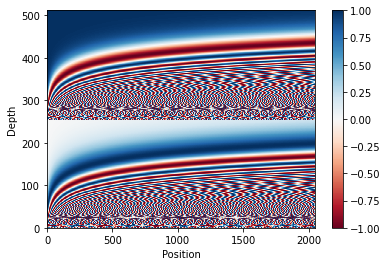

In [ ]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def __call__(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=1371,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=1276,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=1371, target_vocab_size=1276, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 1276])

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

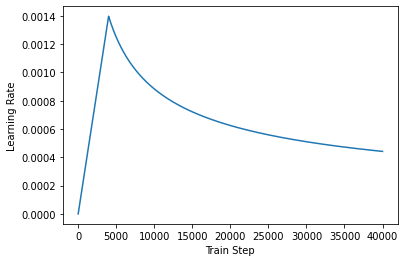

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.en.get_vocab_size(),
    target_vocab_size=tokenizers.py.get_vocab_size(), 
    pe_input=1000, 
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
latest = tf.train.latest_checkpoint("/content/drive/MyDrive/checkpoints")
print(latest)
temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
transformer.load_weights(latest)

/content/drive/MyDrive/checkpoints/best_transformer


In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 1

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
print(train_batches)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>


In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    
  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 7.2348 Accuracy 0.0000
Epoch 1 Batch 50 Loss 7.0865 Accuracy 0.0020
Epoch 1 Batch 100 Loss 6.8712 Accuracy 0.0449
Epoch 1 Batch 150 Loss 6.6851 Accuracy 0.0649
Epoch 1 Batch 200 Loss 6.5067 Accuracy 0.0802
Epoch 1 Loss 6.3806 Accuracy 0.0897
Time taken for 1 epoch: 34.00 secs



In [ ]:
def evaluate(sentence, max_length=60):
  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.en.tokenize(sentence).to_tensor()

  encoder_input = sentence
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.py.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)
    
  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.py.detokenize(output)[0] # shape: ()
  
  tokens = tokenizers.py.lookup(output)[0]
  return text, tokens, attention_weights

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = "for every a in lista,"
ground_truth = "for a in list:"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)
# print(attention_weights)

Input:         : for every a in lista,
Prediction     : for in listaaa
Ground truth   : for a in list:


In [ ]:
sentence = "import module json"
ground_truth = "import json"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : import module json
Prediction     : import json
Ground truth   : import json


In [ ]:
sentence = "c is equals to a plus b "
ground_truth = "c = a + b"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : c is equals to a plus b 
Prediction     : c = plusul
Ground truth   : c = a + b


In [ ]:
sentence = "import module tensorflow."
ground_truth = "import tensorflow"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : import module tensorflow.
Prediction     : import tensionsolowowow ( )
Ground truth   : import tensorflow


In [ ]:
sentence = "call the calculate function."
ground_truth = "calculate()"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : call the calculate function.
Prediction     : calulate ( )
Ground truth   : calculate()


In [ ]:
sentence = "call the foo function with a as the argument."
ground_truth = "foo(a)"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : call the foo function with a as the argument.
Prediction     : foooo ( fo )
Ground truth   : foo(a)


In [ ]:
sentence = "a is a string 'adfs' "
ground_truth = "a = 'adfs' "

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : a is a string 'adfs' 
Prediction     : isffors = ' ad '
Ground truth   : a = 'adfs' 


In [ ]:
sentence = "if a is smaller than b,"
ground_truth = "if a > b:"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : if a is smaller than b,
Prediction     : if b < b :
Ground truth   : if a > b:


In [ ]:
sentence = "while a is not equal to 5,"
ground_truth = "while a !=5 :"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : while a is not equal to 5,
Prediction     : while not found ! = 4 :
Ground truth   : while a !=5 :


In [ ]:
sentence = "increment height by integer 5"
ground_truth = "i = i + 5"

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : increment height by integer 5
Prediction     : height + = 2
Ground truth   : i = i + 5


In [ ]:
infer_signature = transformer.call.get_concrete_function(
  tf.TensorSpec(shape=[None, None], dtype=tf.int64, name='encoder_input'), # encoder_input
  tf.TensorSpec(shape=[None, None], dtype=tf.int64, name='tar_input'), # tar_input
  tf.TensorSpec(shape=None, dtype=tf.bool, name='train'), # training
  tf.TensorSpec(shape=[4, None], dtype=tf.float32, name='enc_padding_mask'), # enc_padding_mask
  tf.TensorSpec(shape=[4, None], dtype=tf.float32, name='combined_mask'), # combined_mask
  tf.TensorSpec(shape=[4, None], dtype=tf.float32, name='dec_padding_mask')  # dec_padding_mask
)

tf.keras.models.save_model(
    transformer, "/saved_model/transformer83", overwrite=True, include_optimizer=True, save_format=None,
    signatures=infer_signature, options=None, save_traces=True
)

NameError: ignored

In [ ]:
tf.saved_model.save(transformer, "/saved_model/transformer83")

NameError: ignored

In [ ]:
transformer.save('my_model.h5')

In [ ]:
tranformer = Transformer

In [ ]:
transformer = tf.keras.Model.load_weights("besttranformer.h5")

TypeError: ignored